In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing as pre, decomposition
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import skew
from scipy.special import boxcox1p
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns
import operator

### Import

In [3]:
train = pd.read_csv('train.csv')

train = train.drop(['Id','Alley','PoolQC','Fence','MiscFeature','FireplaceQu'], axis = 1) # sparse features
train = train[train['LotArea']<55000] # outliers

# MSSubClass looks like an integeter but it's really a categorical variable
train['MSSubClass'] = train['MSSubClass'].astype(str)

# fill nas of strings with 'Unkown'
string_cols = train.select_dtypes(include = object).columns
for column in string_cols:
    train[column] = train[column].fillna('Unknown')

# fill nas of numbers with mean
number_cols = train.select_dtypes(include = [int,float]).columns
for column in number_cols:
    train[column] = train[column].astype(float).fillna(train[column].mean())

### Remove Collinearity

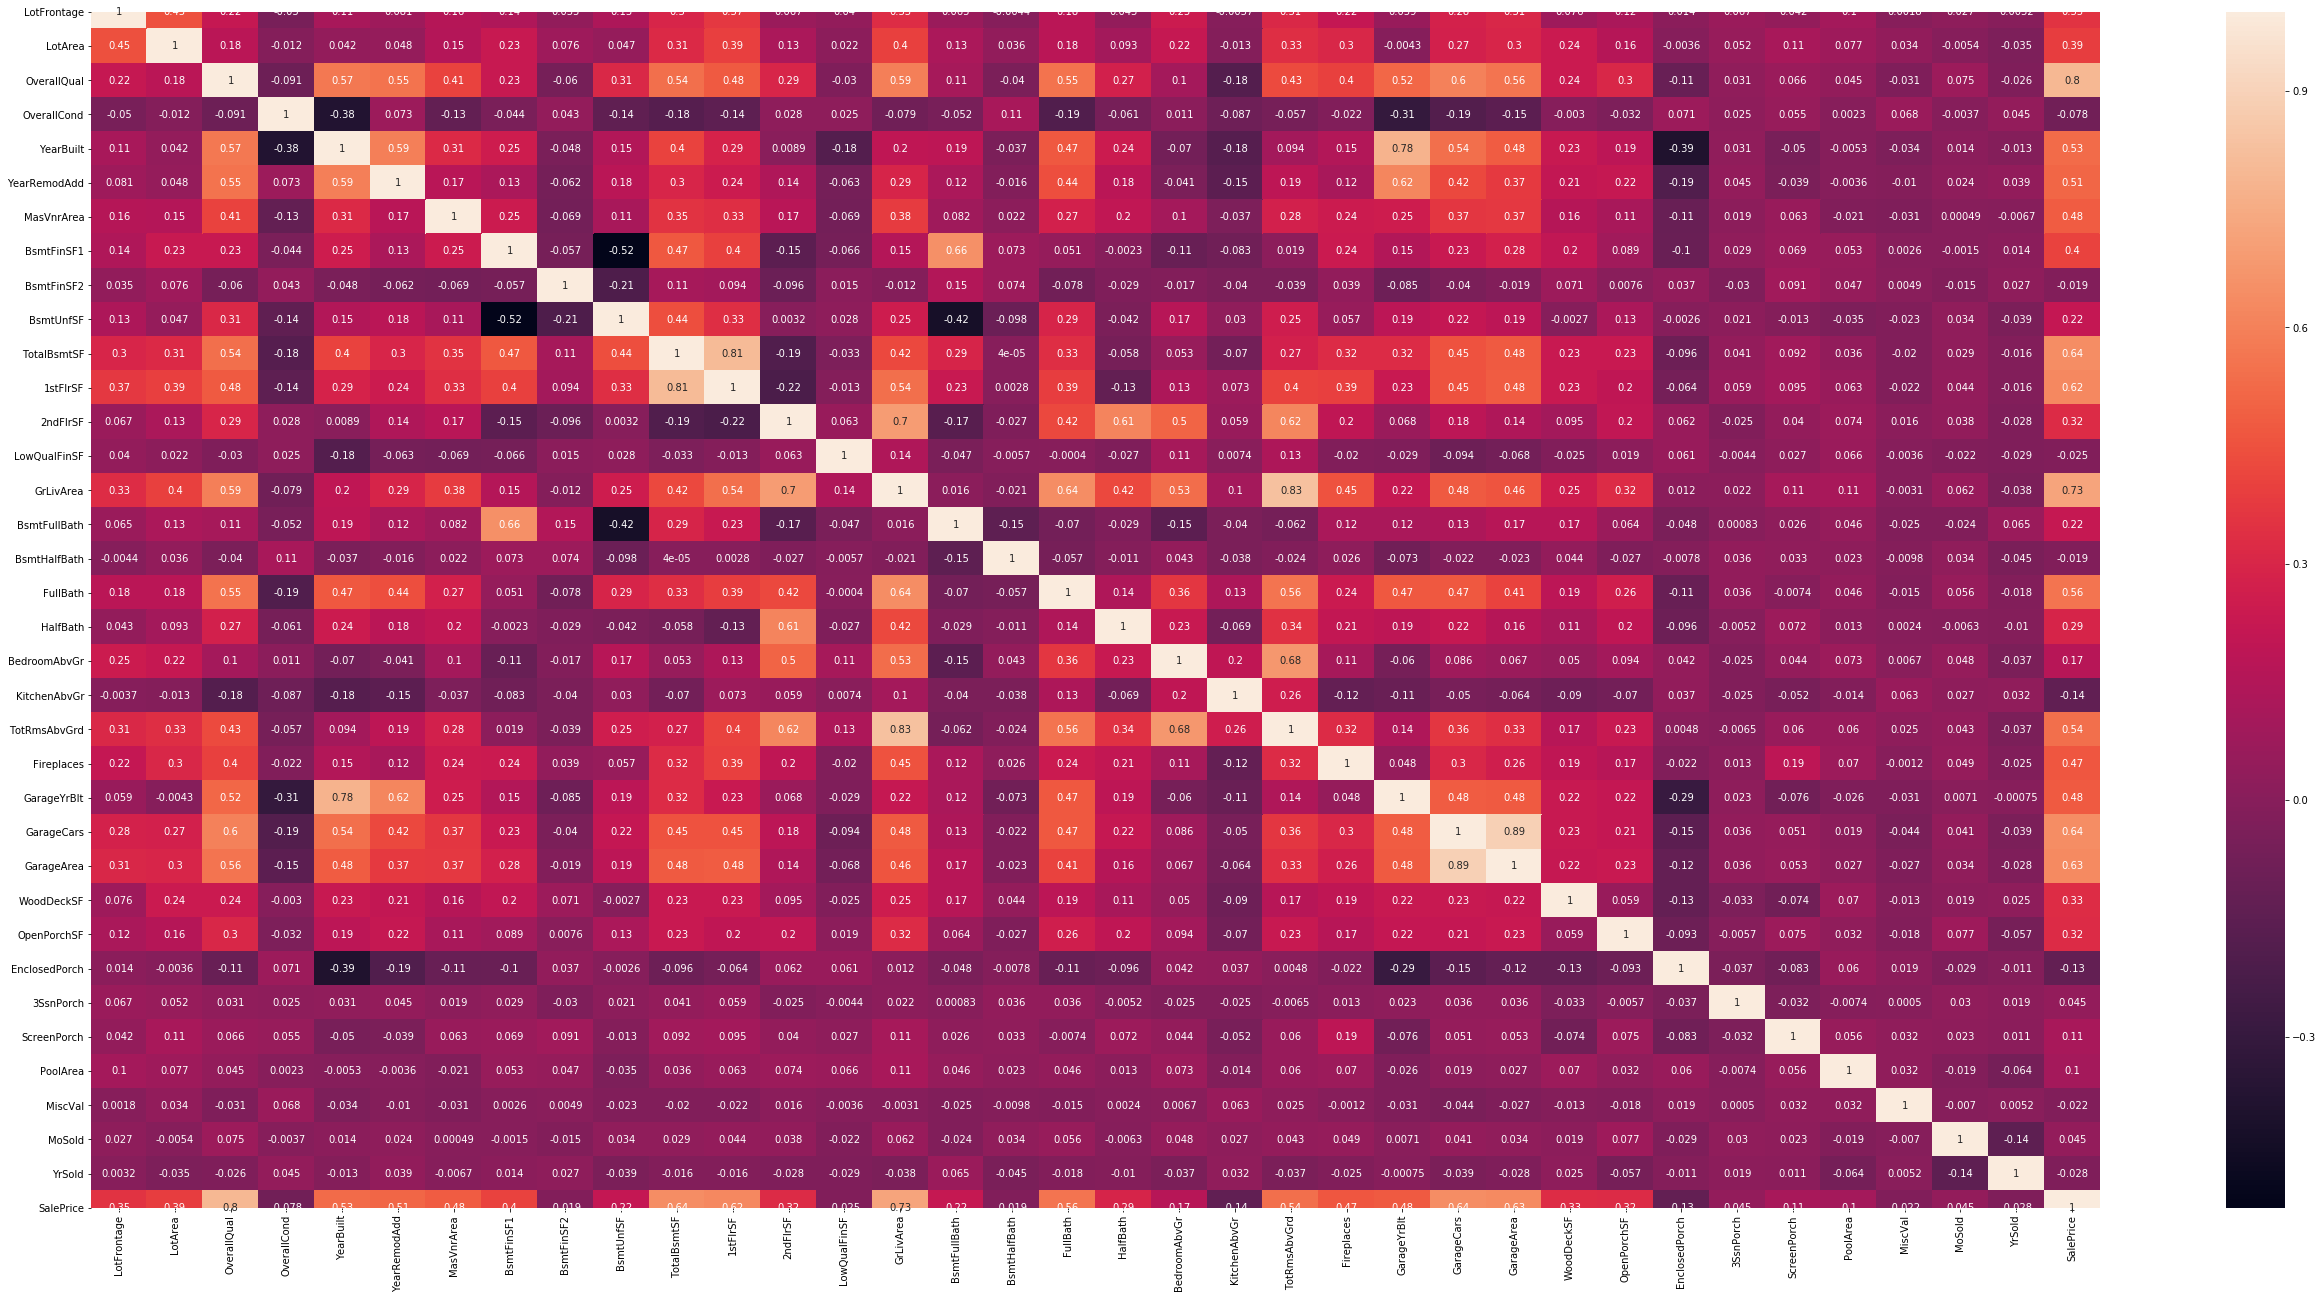

In [5]:
plt.figure(figsize=[45,22])
sns.heatmap(train.corr(), annot=True);

In [6]:
# when two features are highly correlated, drop the one less correlated with saleprice
train = train.drop(['GarageArea','1stFlrSF','TotRmsAbvGrd','2ndFlrSF'], axis=1)

In [7]:
x = train[[i for i in train.columns if i != 'SalePrice']] # split out the target variable
y = train[['SalePrice']]

### Data Prep

In [8]:
# skew correction
skewed_vars = pd.DataFrame(columns = ['skew'], data = x.skew(numeric_only = True))
skewed_vars = skewed_vars[(skewed_vars['skew'] > 0.5) | (skewed_vars['skew'] < -0.5)]
vars_to_transform = list(skewed_vars.index)

for var in vars_to_transform:
    x[var] = boxcox1p(x[var],0.1)

y['SalePrice'] = np.log(y['SalePrice'])

In [9]:
x = pd.get_dummies(x)

In [10]:
# 20% of data held separate for validation
train_x, test_x, train_y, test_y = train_test_split(x, y, train_size = 0.8, test_size = 0.2, random_state = 42)

In [11]:
# *** STANDARDIZATION ***
scaler = pre.StandardScaler().fit(train_x) 
train_x = pd.DataFrame(scaler.transform(train_x), index = train_x.index, columns = train_x.columns)
# this warning is caused by the dummy variables being ints, not floats

### Feature Selection

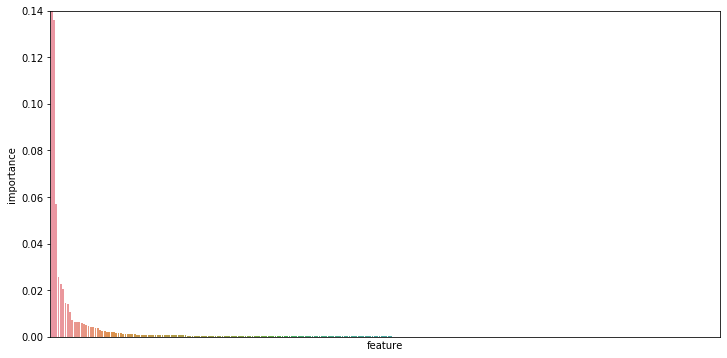

37 features retained
95.22% variance still explained


In [25]:
# Because there are so many features, we'll use a 'random forest' to select the features with greatest importance
clf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=1)
clf.fit(train_x, train_y.values.ravel())

feature_importances = list(zip(train_x.columns, clf.feature_importances_))
sorted_importances = sorted(feature_importances, key = operator.itemgetter(1), reverse = True)
importances = pd.DataFrame(data = sorted_importances, columns = ['feature','importance'])

plt.figure(figsize = (12,6,))
sns.barplot(x = importances['feature'], y = importances['importance'],);
plt.ylim(0,0.14)
plt.xticks([])
plt.show()

print(str(len(importances[importances['importance'] > 0.001]))+" features retained")
print(str(round(importances[importances['importance'] > 0.001]['importance'].sum()*100,2))+"% variance still explained")

In [26]:
important_features = list(importances[importances['importance'] > 0.001]['feature'])
restricted_x = train_x[important_features]

### Model Training & Validation

In [27]:
# *** TRAIN MODEL ***
reg =Lasso(alpha =0.001, random_state=1)
scores = cross_val_score(reg, restricted_x, train_y, cv = 5) # we're using cross validation with 5 folds to interrogate accuracy
print("mean accuracy is "+str(round(scores.mean()*100,2))+"%")
reg.fit(restricted_x,train_y)

mean accuracy is 89.21%


Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=1,
      selection='cyclic', tol=0.0001, warm_start=False)

In [28]:
test_x = pd.DataFrame(scaler.transform(test_x), index = test_x.index, columns = test_x.columns)
restricted_x = test_x[important_features]

In [29]:
log_result = reg.predict(restricted_x)

In [30]:
result = np.exp(log_result)

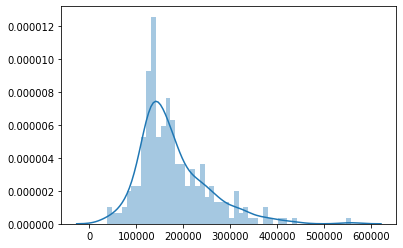

In [31]:
# transform back
test_y = np.exp(test_y)
sns.distplot(test_y, bins = 50);

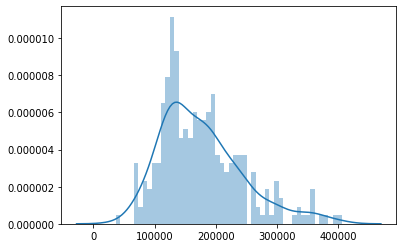

In [32]:
sns.distplot(result, bins = 50);

In [33]:
print("accuracy on the holdout dataset is "+str(round(r2_score(test_y, result)*100,2))+"%")

accuracy on the holdout dataset is 90.66%
